In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#导入强大的绘图库
import torch#一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别.

In [2]:
#设置随机种子
import random
torch.backends.cudnn.deterministic = True   #将cudnn框架中的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False      #关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
train_df=pd.read_csv("DailyDelhiClimateTrain.csv")
print(f"len(train_df):{len(train_df)}")
train_df.head()

len(train_df):1462


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
meantemp=train_df['meantemp'].values
print(f"len(meantemp):{len(meantemp)}")

len(meantemp):1462


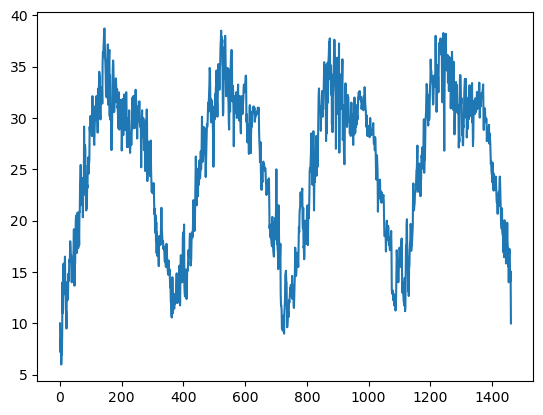

In [5]:
plt.plot([i for i in range(len(meantemp))],meantemp)

In [6]:
from sklearn.preprocessing import MinMaxScaler
# 创建MinMaxScaler对象
scaler = MinMaxScaler()
# 将数据进行归一化
meantemp = scaler.fit_transform(meantemp.reshape(-1,1))

In [7]:
def split_data(data, time_step=12):
    dataX=[]
    datay=[]
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
    dataX = np.array(dataX).reshape(len(dataX),time_step,-1)
    datay = np.array(datay)
    return dataX,datay

In [8]:
dataX,datay=split_data(meantemp,time_step=12)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape}")

dataX.shape:(1450, 12, 1),datay.shape:(1450, 1)


In [9]:
#划分训练集和测试集的函数
def train_test_split(dataX, datay, shuffle=True, percentage=0.8):
    """
    将训练数据X和标签y以numpy.array数组的形式传入
    划分的比例定为训练集:测试集=8:2
    """
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [10]:
train_X,train_y,test_X,test_y = train_test_split(dataX, datay, shuffle=False, percentage=0.8)
print(f"train_X.shape:{train_X.shape},test_X.shape:{test_X.shape}")

train_X.shape:(1160, 12, 1),test_X.shape:(290, 12, 1)


In [11]:
X_train, y_train = train_X , train_y    #源数据要被打乱，故重新赋值

In [12]:
# 定义CNN+LSTM模型类
class CNN_LSTM(nn.Module):
    
    def __init__(self, conv_input, input_size, hidden_size, num_layers, output_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.conv(x)
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [13]:
%%time 

test_X1=torch.Tensor(test_X)
test_y1=torch.Tensor(test_y)

# 定义输入、隐藏状态和输出维度
input_size = 1  # 输入特征维度
conv_input = 12
hidden_size = 64  # LSTM隐藏状态维度
num_layers = 5  # LSTM层数
output_size = 1  # 输出维度（预测目标维度）

# 创建CNN_LSTM模型实例
model = CNN_LSTM(conv_input,input_size, hidden_size, num_layers, output_size)

#训练周期为500次
num_epochs = 500
batch_size = 64#一次训练的数量
#优化器
optimizer=optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))
#损失函数
criterion=nn.MSELoss()
train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(num_epochs):
    
    random_num = [i for i in range(len(train_X))]
    np.random.shuffle(random_num)
    
    train_X = train_X[random_num]
    train_y = train_y[random_num]
    
    train_X1 = torch.Tensor(train_X[:batch_size])
    train_y1 = torch.Tensor(train_y[:batch_size])
    
    #训练
    model.train()
    #将梯度清空
    optimizer.zero_grad()
    #将数据放进去训练
    output = model(train_X1)
    #计算每次的损失函数
    train_loss = criterion(output,train_y1)
    #反向传播
    train_loss.backward()
    #优化器进行优化(梯度下降,降低误差)
    optimizer.step()
    
    if epoch%50 == 0:
        model.eval()
        with torch.no_grad():
            output=model(test_X1)
            test_loss=criterion(output,test_y1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")

start
epoch:0,train_loss:0.3825515806674957,test_loss:0.5205779671669006
epoch:50,train_loss:0.15361317992210388,test_loss:0.21401630342006683
epoch:100,train_loss:0.050702545791864395,test_loss:0.048538438975811005
epoch:150,train_loss:0.05920787900686264,test_loss:0.045882757753133774
epoch:200,train_loss:0.04800529405474663,test_loss:0.04092799499630928
epoch:250,train_loss:0.04774784296751022,test_loss:0.03745449334383011
epoch:300,train_loss:0.02255822718143463,test_loss:0.018428979441523552
epoch:350,train_loss:0.006773088127374649,test_loss:0.005251636262983084
epoch:400,train_loss:0.005747809074819088,test_loss:0.004969146568328142
epoch:450,train_loss:0.006684308405965567,test_loss:0.0046675922349095345
CPU times: total: 14.1 s
Wall time: 4.29 s


In [14]:
def mse(pred_y,true_y):
    return np.mean((pred_y-true_y) ** 2)

In [15]:
train_X1 = torch.Tensor(X_train)
train_pred = model(train_X1).detach().numpy()
test_pred = model(test_X1).detach().numpy()
pred_y = np.concatenate((train_pred,test_pred))
pred_y = scaler.inverse_transform(pred_y).T[0]
true_y = np.concatenate((y_train,test_y))
true_y = scaler.inverse_transform(true_y).T[0]
print(f"mse(pred_y,true_y):{mse(pred_y,true_y)}")

mse(pred_y,true_y):5.537220612952564


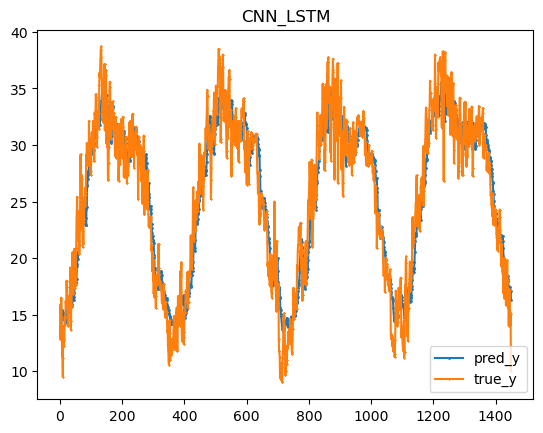

In [16]:
plt.title("CNN_LSTM")
x = [i for i in range(len(true_y))]
plt.plot(x,pred_y,marker="o",markersize=1,label="pred_y")
plt.plot(x,true_y,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()